/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3172 - loss: 1.6043 - val_accuracy: 0.3750 - val_loss: 1.1012
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3409 - loss: 1.4724 - val_accuracy: 0.5000 - val_loss: 1.0218
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4163 - loss: 1.1950 - val_accuracy: 0.6786 - val_loss: 0.9419
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5533 - loss: 1.0316 - val_accuracy: 0.7500 - val_loss: 0.8770
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6509 - loss: 0.8653 - val_accuracy: 0.8036 - val_loss: 0.8256
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5904 - loss: 0.9610 - val_accuracy: 0.8571 - val_loss: 0.7816
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6241 - loss: 0.8488 - val_accuracy: 0.8214 - val_loss: 0.7512
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7236 - loss: 0.7358 - val_accuracy: 0.8393 - val_loss: 0

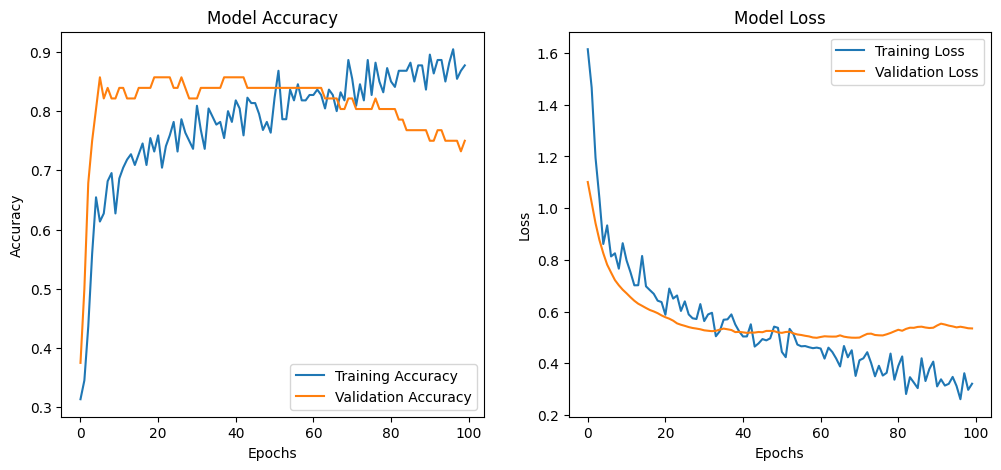

Saved artifact at '/tmp/tmpqpunfgcy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 18), dtype=tf.float32, name='keras_tensor_41')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138191487275904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138191487277136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138191487286288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138191487277488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138191487273616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138191487276784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138191487285584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138191494504944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138191487161216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138191487157520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138191487171952: Ten

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

# Constants
NUM_EPOCHS = 100
BATCH_SIZE = 32

# Load and preprocess dataset
data = pd.read_csv('/content/cirrhosis.csv')  # Replace with actual dataset path
data.dropna(inplace=True)  # Drop rows with missing values

# Encode categorical variables
label_encoders = {}
categorical_columns = ['Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Drug']
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Save encoder for potential inverse transformation if needed

# Encode the target labels
label_encoder = LabelEncoder()
data['Status'] = label_encoder.fit_transform(data['Status'])  # Convert 'C', 'D', etc. to integers

# Split features and target
X = data.drop(columns=['Status', 'ID'])  # 'Status' as target; adjust if you have a different target column
y = data['Status']  # Using 'Status' as the target

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert target to categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Build the model
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(y_train.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

# Plot training history for visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Save the model in HDF5 format
model.save("cirrhosis_model.h5")

# Convert to TensorFlow Lite model with integer-only quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Representative dataset function for quantization
def representative_data_gen():
    for i in range(100):
        yield [X_train[i:i+1].astype(np.float32)]

converter.representative_dataset = representative_data_gen
tflite_model = converter.convert()

# Save the quantized model as .tflite
with open("cirrhosis_model.tflite", "wb") as f:
    f.write(tflite_model)

# Helper function to generate .h file from .tflite model
def generate_c_array(hex_data, var_name):
    c_array = f'#ifndef {var_name.upper()}_H\n#define {var_name.upper()}_H\n\n'
    c_array += f'const unsigned int {var_name}_len = {len(hex_data)};\n'
    c_array += f'const unsigned char {var_name}[] = {{\n'
    c_array += ', '.join(f'0x{b:02x}' for b in hex_data) + '\n};\n\n#endif\n'
    return c_array

# Write .tflite model to .h file
with open("cirrhosis_model.h", 'w') as f:
    f.write(generate_c_array(tflite_model, "cirrhosis_model"))

# Generate .h files for test and train data
def to_c_array(data, var_name):
    c_array = f'float {var_name}[] = {{'
    c_array += ', '.join(f'{x:.6f}f' for x in data.flatten())
    c_array += '};\n'
    return c_array

with open("x_train.h", 'w') as f:
    f.write(to_c_array(X_train[:70], 'x_train'))

with open("x_test.h", 'w') as f:
    f.write(to_c_array(X_test[:70], 'x_test'))

print("Model conversion and .h file generation complete.")
